# ScoreSight - Top Goal Scorer Prediction
Author: Rishi Khandekar  
Internship: Infosys  
Goal: Predict total goals scored by a player in a season (regression)

In [1]:
!pip install seaborn xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.05)

In [3]:
df = pd.read_csv("topgoals.csv")
print("Shape:", df.shape)
display(df.head())

Shape: (324, 20)


,Season,Rank,Player,Club,Goals,Position,Age,Appearances,Minutes_Played,Goals_prev_season,Assists,Penalty_Goals,Non-Penalty_Goals,Goals_per_90,Big_6_Club_Feature,Club_League_Rank,Club_Total_Goals,League_Goals_per_Match,Games_in_Season,Goals_last_3_seasons_avg
0,2023-24,1,Erling Haaland,Manchester City,27,Forward,23,31,2682,36,6,1.0,26,0.87,1,1,96,2.83,38.0,31.50
1,2023-24,2,Cole Palmer,Chelsea,22,Attacking Midfielder,22,33,2674,3,11,9.0,13,0.74,1,6,77,2.83,38.0,13.33
2,2023-24,3,Alexander Isak,Newcastle United,21,Forward,24,30,2403,10,2,5.0,16,0.79,0,7,85,2.83,38.0,13.00
3,2023-24,4,Ollie Watkins,Aston Villa,19,Forward,28,37,3302,15,13,0.0,19,0.52,0,4,76,2.83,38.0,14.67
4,2023-24,4,Dominic Solanke,AFC Bournemouth,19,Forward,26,38,3355,6,3,1.0,18,0.51,0,12,54,2.83,38.0,10.00


In [4]:
print("Columns:", df.columns.tolist())
print("\nDtypes:")
print(df.dtypes)
print("\nMissing values (count):")
print(df.isnull().sum())

Columns: ['Season', 'Rank', 'Player', 'Club', 'Goals', 'Position', 'Age', 'Appearances', 'Minutes_Played', 'Goals_prev_season', 'Assists', 'Penalty_Goals', 'Non-Penalty_Goals', 'Goals_per_90', 'Big_6_Club_Feature', 'Club_League_Rank', 'Club_Total_Goals', 'League_Goals_per_Match', 'Games_in_Season', 'Goals_last_3_seasons_avg']

Dtypes:
Season                       object
Rank                          int64
Player                       object
Club                         object
Goals                         int64
Position                     object
Age                           int64
Appearances                   int64
Minutes_Played                int64
Goals_prev_season             int64
Assists                       int64
Penalty_Goals               float64
Non-Penalty_Goals             int64
Goals_per_90                float64
Big_6_Club_Feature            int64
Club_League_Rank              int64
Club_Total_Goals              int64
League_Goals_per_Match      float64
Games_in_Season

In [5]:
drop_cols = [
    "Rank", "Player", "Club", "Season", "Games_in_Season",
    "Club_League_Rank", "Club_Total_Goals", "Penalty_Goals", "Non-Penalty_Goals"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
print("Remaining columns:", df.columns.tolist())

Remaining columns: ['Goals', 'Position', 'Age', 'Appearances', 'Minutes_Played', 'Goals_prev_season', 'Assists', 'Goals_per_90', 'Big_6_Club_Feature', 'League_Goals_per_Match', 'Goals_last_3_seasons_avg']


In [6]:
for col in df.columns:
    if df[col].dtype == 'O':
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mode().iloc[0])
    else:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())

print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Goals                       0
Position                    0
Age                         0
Appearances                 0
Minutes_Played              0
Goals_prev_season           0
Assists                     0
Goals_per_90                0
Big_6_Club_Feature          0
League_Goals_per_Match      0
Goals_last_3_seasons_avg    0
dtype: int64


In [7]:
target = "Goals"
if target not in df.columns:
    raise ValueError("Target column 'Goals' not found in dataset.")

candidate_features = [
    "Age", "Position", "Appearances", "Minutes_Played",
    "Goals_prev_season", "Goals_last_3_seasons_avg",
    "Assists", "Goals_per_90", "Big_6_Club_Feature", "League_Goals_per_Match"
]
features = [c for c in candidate_features if c in df.columns]
X = df[features].copy()
y = df[target].copy()

print("Features used:", features)
print("Target stats:")
print(y.describe())

Features used: ['Age', 'Position', 'Appearances', 'Minutes_Played', 'Goals_prev_season', 'Goals_last_3_seasons_avg', 'Assists', 'Goals_per_90', 'Big_6_Club_Feature', 'League_Goals_per_Match']
Target stats:
count    324.000000
mean      17.688272
std        4.873481
min        9.000000
25%       14.000000
50%       17.000000
75%       20.000000
max       36.000000
Name: Goals, dtype: float64


In [8]:
cat_cols = [c for c in ["Position"] if c in X.columns]
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print("Shape after encoding:", X_encoded.shape)
display(X_encoded.head())

Shape after encoding: (324, 12)


,Age,Appearances,Minutes_Played,Goals_prev_season,Goals_last_3_seasons_avg,Assists,Goals_per_90,Big_6_Club_Feature,League_Goals_per_Match,Position_Forward,Position_Midfielder,Position_Winger
0,23,31,2682,36,31.50,6,0.87,1,2.83,True,False,False
1,22,33,2674,3,13.33,11,0.74,1,2.83,False,False,False
2,24,30,2403,10,13.00,2,0.79,0,2.83,True,False,False
3,28,37,3302,15,14.67,13,0.52,0,2.83,True,False,False
4,26,38,3355,6,10.00,3,0.51,0,2.83,True,False,False


In [9]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    return ((series < lb) | (series > ub)).sum()

numeric_cols = X_encoded.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
for col in numeric_cols:
    print(f"{col}: {detect_outliers_iqr(X_encoded[col])} outliers")

Numeric columns: ['Age', 'Appearances', 'Minutes_Played', 'Goals_prev_season', 'Goals_last_3_seasons_avg', 'Assists', 'Goals_per_90', 'Big_6_Club_Feature', 'League_Goals_per_Match']
Age: 1 outliers
Appearances: 9 outliers
Minutes_Played: 7 outliers
Goals_prev_season: 42 outliers
Goals_last_3_seasons_avg: 53 outliers
Assists: 39 outliers
Goals_per_90: 6 outliers
Big_6_Club_Feature: 0 outliers
League_Goals_per_Match: 57 outliers


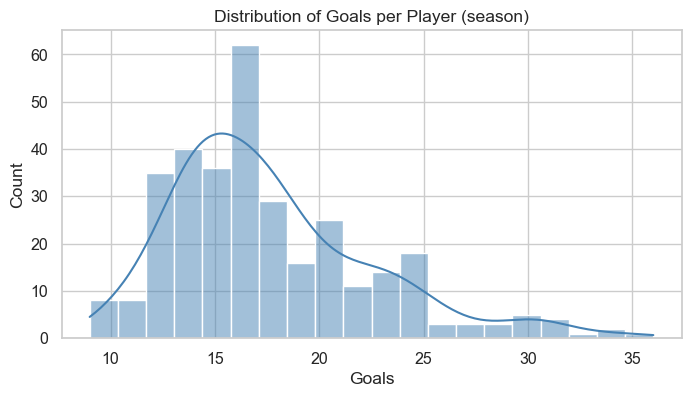

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(y, bins=20, kde=True, color="steelblue")
plt.title("Distribution of Goals per Player (season)")
plt.xlabel("Goals")
plt.ylabel("Count")
plt.show()

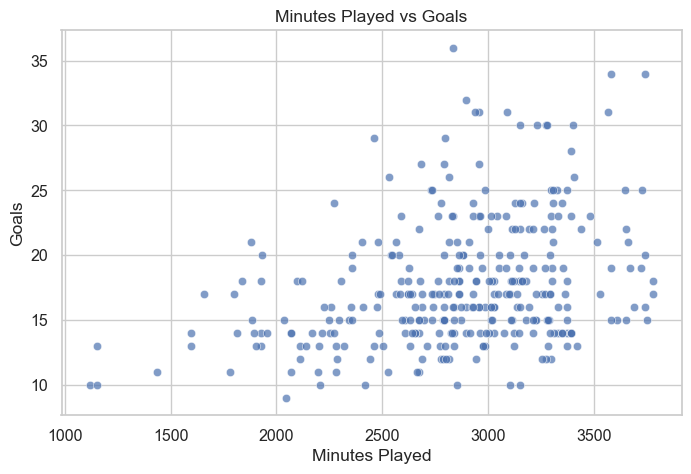

In [11]:
if "Minutes_Played" in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df["Minutes_Played"], y=y, alpha=0.7)
    plt.title("Minutes Played vs Goals")
    plt.xlabel("Minutes Played")
    plt.ylabel("Goals")
    plt.show()

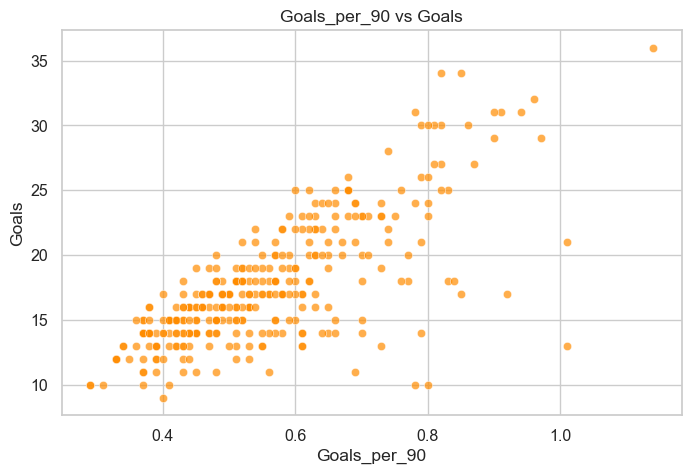

In [12]:
if "Goals_per_90" in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df["Goals_per_90"], y=y, alpha=0.7, color="darkorange")
    plt.title("Goals_per_90 vs Goals")
    plt.xlabel("Goals_per_90")
    plt.ylabel("Goals")
    plt.show()

C:\Users\rishi\AppData\Local\Temp\ipykernel_15124\3047988221.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Position"], y=y, palette=sns.color_palette("Set2", n_pos))


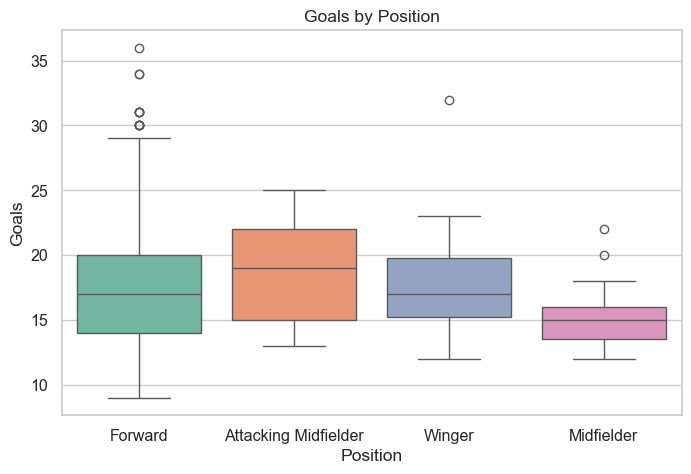

In [13]:
if "Position" in df.columns:
    n_pos = df["Position"].nunique()
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df["Position"], y=y, palette=sns.color_palette("Set2", n_pos))
    plt.title("Goals by Position")
    plt.xlabel("Position")
    plt.ylabel("Goals")
    plt.show()

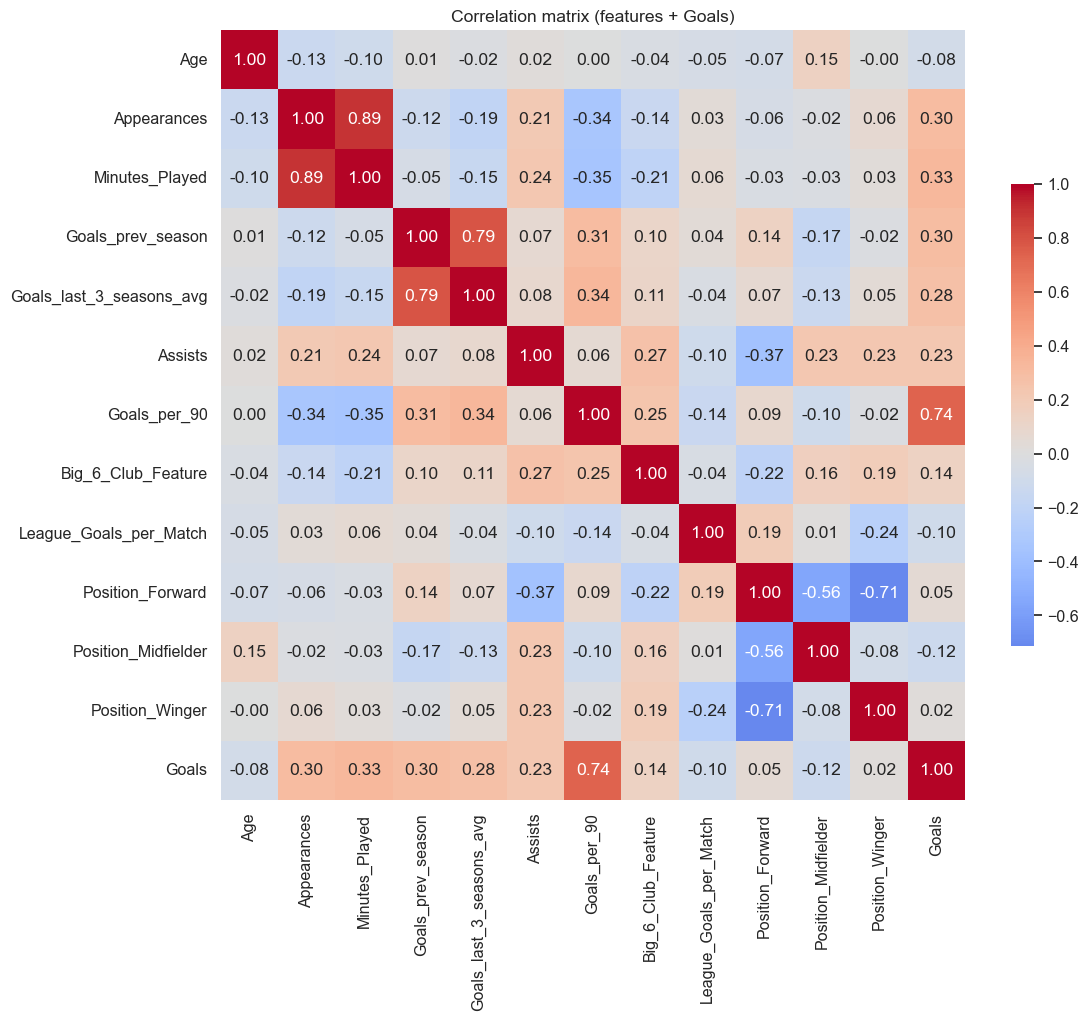

In [14]:
plt.figure(figsize=(12,10))
corr_df = X_encoded.join(y).corr()
sns.heatmap(corr_df, cmap="coolwarm", center=0, annot=True, fmt=".2f", cbar_kws={'shrink':0.6})
plt.title("Correlation matrix (features + Goals)")
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (259, 12) Test shape: (65, 12)


In [16]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("Scaled numeric columns:", num_cols)

Scaled numeric columns: ['Age', 'Appearances', 'Minutes_Played', 'Goals_prev_season', 'Goals_last_3_seasons_avg', 'Assists', 'Goals_per_90', 'Big_6_Club_Feature', 'League_Goals_per_Match']


In [17]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

y_pred_baseline = np.full(shape=len(y_test), fill_value=y_train.mean())
print("Baseline metrics:", regression_metrics(y_test, y_pred_baseline))

Baseline metrics: {'MAE': 3.4291060291060282, 'MSE': 19.855065460470865, 'RMSE': np.float64(4.455902317204773), 'R2': -0.01154770976111652}


In [18]:
def evaluate_regressor(model, X_train, y_train, X_test, y_test, use_scaled=False):
    Xtr = X_train_scaled if use_scaled else X_train
    Xte = X_test_scaled if use_scaled else X_test
    model.fit(Xtr, y_train)
    preds = model.predict(Xte)
    metrics = regression_metrics(y_test, preds)
    print(f"\nModel: {model.__class__.__name__}")
    for k,v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

In [19]:
lin_reg = LinearRegression()
metrics_lin = evaluate_regressor(lin_reg, X_train, y_train, X_test, y_test, use_scaled=True)


Model: LinearRegression
MAE: 0.7321
MSE: 1.5130
RMSE: 1.2301
R2: 0.9229


In [20]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
metrics_rf = evaluate_regressor(rf, X_train, y_train, X_test, y_test, use_scaled=False)


Model: RandomForestRegressor
MAE: 0.7085
MSE: 1.2132
RMSE: 1.1015
R2: 0.9382


In [21]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=200)
metrics_xgb = evaluate_regressor(xgb, X_train, y_train, X_test, y_test, use_scaled=False)


Model: XGBRegressor
MAE: 0.7269
MSE: 1.1322
RMSE: 1.0640
R2: 0.9423


In [22]:
results = pd.DataFrame({
    "LinearRegression": metrics_lin,
    "RandomForest": metrics_rf,
    "XGBoost": metrics_xgb
}).T
display(results)

,MAE,MSE,RMSE,R2
LinearRegression,0.732111,1.513039,1.230056,0.922916
RandomForest,0.708462,1.213204,1.101455,0.938191
XGBoost,0.726919,1.132200,1.064049,0.942318


C:\Users\rishi\AppData\Local\Temp\ipykernel_15124\1647281978.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values[:15], y=fi.index[:15], palette="viridis")


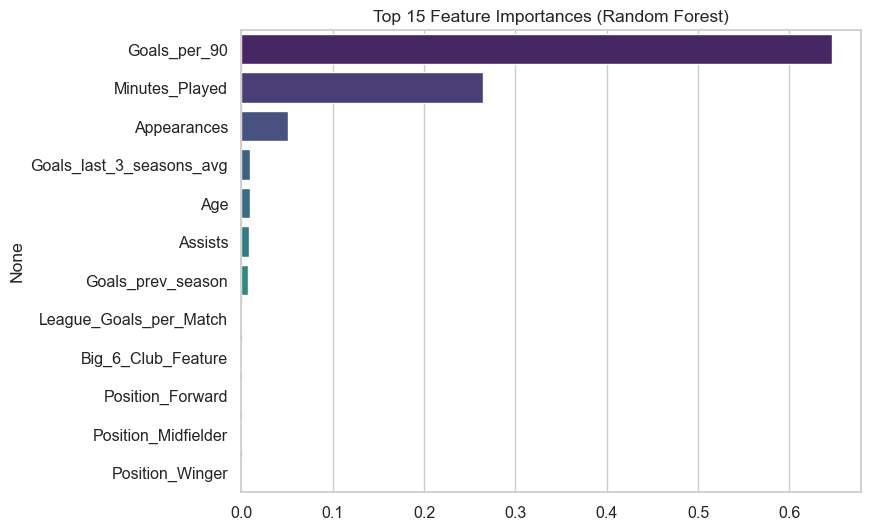

In [23]:
if hasattr(rf, "feature_importances_"):
    fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.values[:15], y=fi.index[:15], palette="viridis")
    plt.title("Top 15 Feature Importances (Random Forest)")
    plt.show()

In [24]:
print("Notebook End - models trained and baseline evaluations complete.")

Notebook End - models trained and baseline evaluations complete.


📌 Base Decision Tree Regressor Performance:
MAE  : 1.0154
MSE  : 2.2769
RMSE : 1.5089
R²   : 0.8840


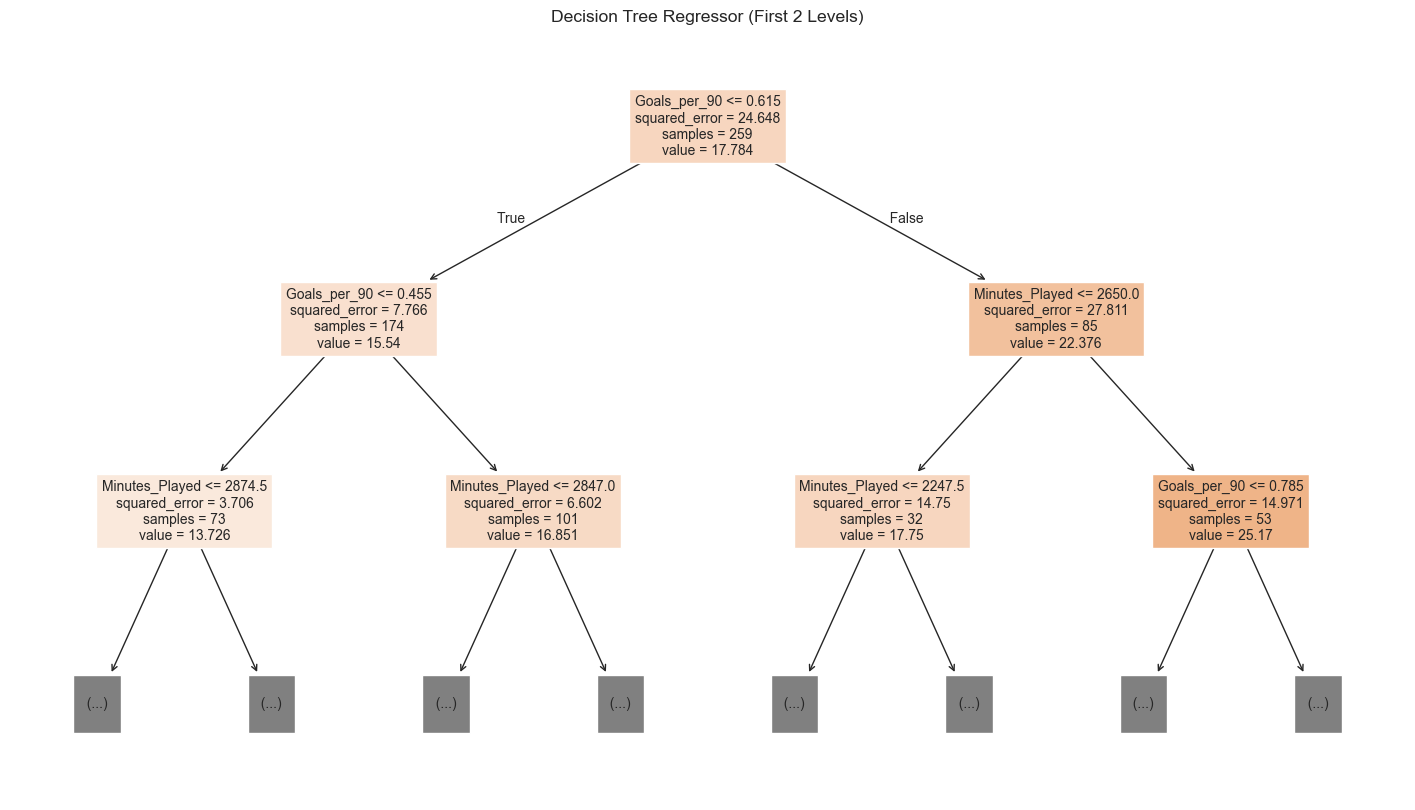

In [25]:
# 14.1 Base Decision Tree (Default)
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_reg.predict(X_test)

# Evaluation Metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("📌 Base Decision Tree Regressor Performance:")
print(f"MAE  : {mae_dt:.4f}")
print(f"MSE  : {mse_dt:.4f}")
print(f"RMSE : {rmse_dt:.4f}")
print(f"R²   : {r2_dt:.4f}")

# 14.2 Visualize Tree Structure
plt.figure(figsize=(18,10))
plot_tree(dt_reg, feature_names=X_train.columns, filled=True, max_depth=2, fontsize=10)
plt.title("Decision Tree Regressor (First 2 Levels)")
plt.show()

In [26]:
# 14.4 Hyperparameter Tuning (GridSearchCV)
param_grid = {
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_dt_reg = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

grid_dt_reg.fit(X_train, y_train)

print("Best Parameters:", grid_dt_reg.best_params_)
print("Best CV R² Score:", grid_dt_reg.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV R² Score: 0.8907796699492044


In [27]:
# 14.5 Tuned Decision Tree Evaluation
best_dt = grid_dt_reg.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best_dt)
mse_best = mean_squared_error(y_test, y_pred_best_dt)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best_dt)

print("\n📌 Tuned Decision Tree Regressor Performance:")
print(f"MAE  : {mae_best:.4f}")
print(f"MSE  : {mse_best:.4f}")
print(f"RMSE : {rmse_best:.4f}")
print(f"R²   : {r2_best:.4f}")

# Optionally compare with Week 3 models (already stored in results DataFrame)
if 'results' in globals():
    results.loc['DecisionTree_Base'] = [mae_dt, mse_dt, rmse_dt, r2_dt]
    results.loc['DecisionTree_Tuned'] = [mae_best, mse_best, rmse_best, r2_best]
    display(results)



📌 Tuned Decision Tree Regressor Performance:
MAE  : 1.0154
MSE  : 2.2769
RMSE : 1.5089
R²   : 0.8840


,MAE,MSE,RMSE,R2
LinearRegression,0.732111,1.513039,1.230056,0.922916
RandomForest,0.708462,1.213204,1.101455,0.938191
XGBoost,0.726919,1.132200,1.064049,0.942318
DecisionTree_Base,1.015385,2.276923,1.508948,0.883999
DecisionTree_Tuned,1.015385,2.276923,1.508948,0.883999
